# Flocking models

## The Vicsek model

This model is a simple description of collective behavior. It is an agent-based model, where the behavior of each individual is computed to understand the properties of the group.

The simulation takes place in a square with side length $L$ using periodic boundary conditions, with the square containing $N$ agents.

Each agent has a position $\mathbf{x}_i$ and orientation $\theta_i$, with velocity $\mathbf{v}_i$ is computed from $\theta_i$. All agents move at the same speed $v$.

The update step for the model is
\begin{align}
  \mathbf{x}_i(t+\Delta t) &= \mathbf{x}_i(t) + \mathbf{v}_i(t) \Delta t\\
  \theta_i(t+\Delta t) &= \langle\theta(t)\rangle_r + \Delta\theta,
\end{align}
where $\langle\theta(t)\rangle_r$ is the average orientation of all agents within a distance $r$, given by
\begin{align}
  \langle\theta(t)\rangle_r = \arctan\left(\frac{\langle\sin(\theta(t)\rangle_r}{\langle\cos(\theta(t)\rangle_r}\right).
\end{align}
The term $\Delta\theta$ is a noise term drawn from a uniform probability distribution $[-\eta/2,\eta/2]$.

As the radius $r$ is used as the length scale and $\Delta{}t$ is used as the time scale, the parameters are
- $N$, the number of agents,
- $L$, the size of the simulation space,
- $\eta$, the strength of the noise term, and
- $v$, the speed of each agent (distance per update step).

## Demo

An interactive implementation of the Vicsek model is included below.

In [ ]:
from IPython.display import IFrame

IFrame(src='./vicsek.html', width=1000, height=600)

## Order parameter

One question we may ask about the simulation at any particular time step is the degree of synchronization among the group. If the entire group is moving in the same direction, the simulation is in a state of complete order, while a completely uncoordinated group would be expected to have an average velocity of zero.

The order parameter is a useful metric for quantifying the state of the system. It is defined as the average velocity normalized to 1,
\begin{align}
  \phi = \frac{1}{Nv}\left|\sum_{i=1}^N\mathbf{v}_i\right|.
\end{align}
A value of $\phi=1$ indicates a state of complete order, while a value of $\phi=0$ indicates a state of complete disorder.

## Phase transitions

The order parameter is a useful tool for answering questions about how changes to the parameters affect the behavior of the group. One way to explore the parameter space is to try slowly changing one of the sliders in the demo above.

A Python implementation of the Vicsek model allows a programmatic approach.

In [ ]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

class Vicsek:
    def __init__(self, num_agents, size, noise_mag, speed):
        self.num_agents = min(num_agents, 1000)
        self.size = size
        self.noise_mag = noise_mag
        self.speed = speed
        
        self.pos = size * np.random.rand(num_agents, 2)
        self.phase = 2 * math.pi * np.random.rand(num_agents) - math.pi

    def distance(self, i, j):
        d = np.abs(self.pos[i, :] - self.pos[j, :])

        if d[0] >= 0.5*self.size:
            d[0] -= self.size
        if d[1] >= 0.5*self.size:
            d[1] -= self.size

        return np.linalg.norm(d)

    def neighbor_avg(self, i):
        csum = 0
        ssum = 0
        count = 0
    
        for j in range(self.num_agents):
            if self.distance(i, j) < 1:
                csum += np.cos(self.phase[j])
                ssum += np.sin(self.phase[j])
                count += 1

        return np.arctan2(ssum/count, csum/count) if count != 0 else 0

    def update(self):
        for i in range(self.num_agents):
            self.pos[i, 0] += self.speed * np.cos(self.phase[i])
            self.pos[i, 1] += self.speed * np.sin(self.phase[i])
            self.phase[i] = self.neighbor_avg(i) + random.uniform(-0.5*self.noise_mag, 0.5*self.noise_mag)

            if self.pos[i, 0] >= self.size:
                self.pos[i, 0] -= self.size
            elif self.pos[i, 0] < self.size:
                self.pos[i, 0] += self.size
            if self.pos[i, 1] >= self.size:
                self.pos[i, 1] -= self.size
            elif self.pos[i, 1] < self.size:
                self.pos[i, 1] += self.size

            if self.phase[i] >= math.pi:
                self.phase[i] -= math.pi
            elif self.phase[i] < -math.pi:
                self.phase[i] += math.pi

    def get_order(self):
        sumx = np.sum(np.cos(self.phase[0:self.num_agents]))
        sumy = np.sum(np.sin(self.phase[0:self.num_agents]))

        return np.linalg.norm([sumx, sumy]) / self.num_agents

## Noise

Text(0.5, 0, 'Noise')

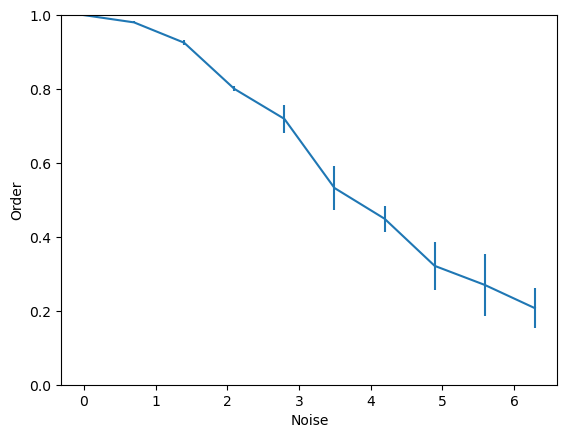

In [3]:
runs = 5
noise = np.linspace(0, 6.29, 10)
order = np.zeros((len(noise), runs))

for r in range(runs):
    for i in range(len(noise)):
        v = Vicsek(50, 3, noise[i], 0.03)
        for j in range(50):
            v.update()
        order[i, r] = v.get_order()

plt.errorbar(noise, np.average(order, axis=1), yerr=np.std(order, axis=1))
plt.ylim(0,1)
plt.ylabel("Order")
plt.xlabel("Noise")

## Density

In [4]:
runs = 5
size = np.linspace(2, 15, 10)
order = np.zeros((len(size), runs))

for r in range(runs):
    for i in range(len(size)):
        v = Vicsek(50, size[i], 2.0, 0.03)
        for j in range(50):
            v.update()
        order[i, r] = v.get_order()

plt.errorbar(50/size, np.average(order, axis=1), yerr=np.std(order, axis=1))
plt.ylim(0,1)
plt.ylabel("Order")
plt.xlabel("Density")

KeyboardInterrupt: 

## Performance

These examples have used very small numbers of agents, but are still very slow. Why is increasing the number of agents so costly? What can we do about it?

Starling flocks can contain over 1 million birds! How do they avoid this problem?

## Cell array

In [ ]:
class CellArray:
    def __init__(self, size, cell_size):
        self.size = size
        self.cell_size = cell_size
        self.num_cells = int(size/cell_size)
        self.cell_scale = cell_size/size
        
        self.cells = np.zeros((self.num_cells, self.num_cells, 2))
        self.cell_count = np.zeros((self.num_cells, self.num_cells))
        
    def cell_pos(self, x, y):
        return int(x*self.cell_scale), int(y*self.cell_scale)
    
    def get_cell_value(self, i, j):
        return self.cells[i, j, :]
    
    def get_cell_count(self, i, j):
        return self.cell_count[i, j]
    
    def clear_cells(self):
        self.cells[:, :, :] = 0
        self.cell_count[:, :] = 0
    
    def add(self, i, j, cval, sval):
        self.cells[i, j, :] += [cval, sval]
        self.cell_count[i, j] += 1

## Vicsek model with cell array neighbors

In [ ]:
class Vicsek2:
    def __init__(self, num_agents, size, noise_mag, speed):
        self.num_agents = num_agents
        self.size = size
        self.noise_mag = noise_mag
        self.speed = speed

        self.pos = size * np.random.rand(num_agents, 2)
        self.phase = 2 * math.pi * np.random.rand(num_agents) - math.pi

        self.sds = CellArray(size, 1)

    def update_cells(self):
        self.sds.clear_cells()

        for i in range(self.num_agents):
            self.sds.add(*self.sds.cell_pos(*self.pos[i, :]), np.cos(self.phase[i]), np.sin(self.phase[i]))

    def neighbor_avg(self, i):
        sums = np.zeros(2)
        count = 0

        my_ci, my_cj = self.sds.cell_pos(*self.pos[i, :])
        
        for ci in range(my_ci-1, my_ci+2):
            for cj in range(my_cj-1, my_cj+2):
                sums += self.sds.get_cell_value(ci, cj) 
                count += self.sds.get_cell_count(ci, cj)

        return np.arctan2(*(sums/count)) if count != 0 else 0

    def update(self):
        self.update_cells()

        for i in range(self.num_agents):
            self.pos[i, 0] += self.speed * np.cos(self.phase[i])
            self.pos[i, 1] += self.speed * np.sin(self.phase[i])
            self.phase[i] = self.neighbor_avg(i) + random.uniform(-0.5*self.noise_mag, 0.5*self.noise_mag)

            if self.pos[i, 0] >= self.size:
                self.pos[i, 0] -= self.size
            elif self.pos[i, 0] < self.size:
                self.pos[i, 0] += self.size
            if self.pos[i, 1] >= self.size:
                self.pos[i, 1] -= self.size
            elif self.pos[i, 1] < self.size:
                self.pos[i, 1] += self.size

            if self.phase[i] >= math.pi:
                self.phase[i] -= math.pi
            elif self.phase[i] < -math.pi:
                self.phase[i] += math.pi

    def get_order(self):
        sumx = np.sum(np.cos(self.phase[0:self.num_agents]))
        sumy = np.sum(np.sin(self.phase[0:self.num_agents]))

        return np.linalg.norm([sumx, sumy]) / self.num_agents

## Performance with the cell array

Text(0.5, 0, 'Noise')

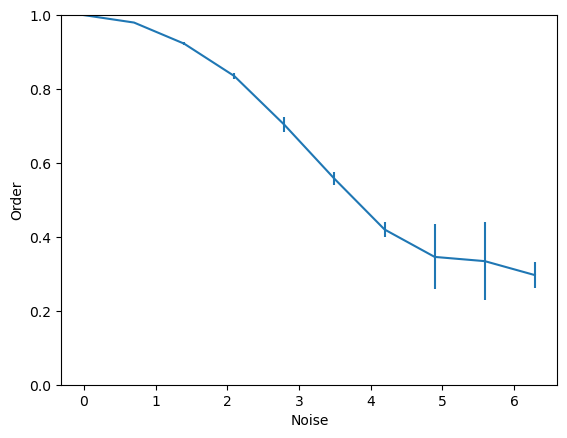

In [ ]:
runs = 5
noise = np.linspace(0, 6.29, 10)
order = np.zeros((len(noise), runs))

for r in range(runs):
    for i in range(len(noise)):
        v = Vicsek2(200, 10, noise[i], 0.03)
        for j in range(50):
            v.update()
        order[i, r] = v.get_order()

plt.errorbar(noise, np.average(order, axis=1), yerr=np.std(order, axis=1))
plt.ylim(0,1)
plt.ylabel("Order")
plt.xlabel("Noise")

## Limitations of the cell array approach

- Is the behavior the same?
- Would this work in 3D?
- Are there new performance concerns?

## The Reynolds model

This model was created with the goal of accurately mimicking the appearance of flocking birds.

The Reynolds model is more detailed than the Vicsek model, while still using an agent-based approach. In this case, each agent has three goals:
- *Cohesion*: Move toward the center of the nearby birds
- *Separation*: Move away from other birds to avoid crashing
- *Alignment*: Accelerate to match the velocity of nearby birds

These goals determine the acceleration $\mathbf{a}(t)$ at a particular time step. Position and velocity are computed as expected:
\begin{align}
    \mathbf{x}(t+\Delta{}t) &= \mathbf{x}(t) + \mathbf{v}(t) \Delta t\\
    \mathbf{v}(t+\Delta{}t) &= \mathbf{v}(t) + \mathbf{a}(t) \Delta t.
\end{align}

In [ ]:
from IPython.display import IFrame

IFrame(src='./reynolds.html', width=1000, height=600)

## Many additions are possible

- Predator that chases the flock
- Obstacles to avoid
- Target or avoid the mouse
- 3D
- Others?

## Many other flocking models are available

- Control theoretic approaches (MPC/cost function)
- Data-driven approaches (ML models)
- Mean-field and continuum models
- Sensory capabilities of the agents
- Effect of the medium (water, air, landscape) on the agents
- Information: if some birds have a target destination, get others to follow